<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>May 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@etu.u-paris.fr</span>
</p>
</CENTER>

## <span id="section-0" style="color:#00B8DE"> 0 - Imports & Parameters </span>

In [ ]:
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
from    scipy.stats             import  norm, johnsonsu, johnsonsb, lognorm
from    scipy.special           import  eval_genlaguerre
from    sklearn.linear_model    import  LinearRegression
import  statsmodels.api         as      sm
import  pandas                  as      pd
from    scipy.interpolate       import  interp1d
import  seaborn                 as      sns
from    math                    import  sqrt, exp

np.random.seed(0)
plt.style.use('ggplot')

In [73]:
r           = 0.05
S0          = 100
sigma       = 0.3
T           = 1
delta       = 1/24 # 10 business days, ie. 2 weeks
dt          = 1/240 # 1 business day

time_grid   = np.arange(0, T, dt)
N           = len(time_grid)-1
M           = 5000
tref        = 1/12
ind_tref    = int(tref/dt)
ind_delta   = int(delta/dt)

alpha       = 0.99

K           = 95

def beta(t):
    return np.exp(-r*t)

In [74]:
def gen_S():
    paths           = np.zeros((M, N+1))
    paths[:, 0]     = S0
    Z               = np.random.normal(0, 1, size=(M, N))
    increments      = np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    paths[:, 1:]    = S0 * np.cumprod(increments, axis=1)
    return paths

S_paths = gen_S()

In [75]:
def gen_mtm_put(S_paths):
    M   = S_paths.shape[0]
    mtm = np.zeros((M, N+1))
    for i in range(N+1):
        d1          = (np.log(S_paths[:, i]/K) + (r + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm[:, i]   = K*beta(T-time_grid[i])*norm.cdf(-d2) - S_paths[:, i]*beta(T-time_grid[i])*norm.cdf(-d1)
    return mtm

mtm_paths       = gen_mtm_put(S_paths)
mtm_diff_paths  = mtm_paths[:, ind_delta:] - mtm_paths[:, :-ind_delta]

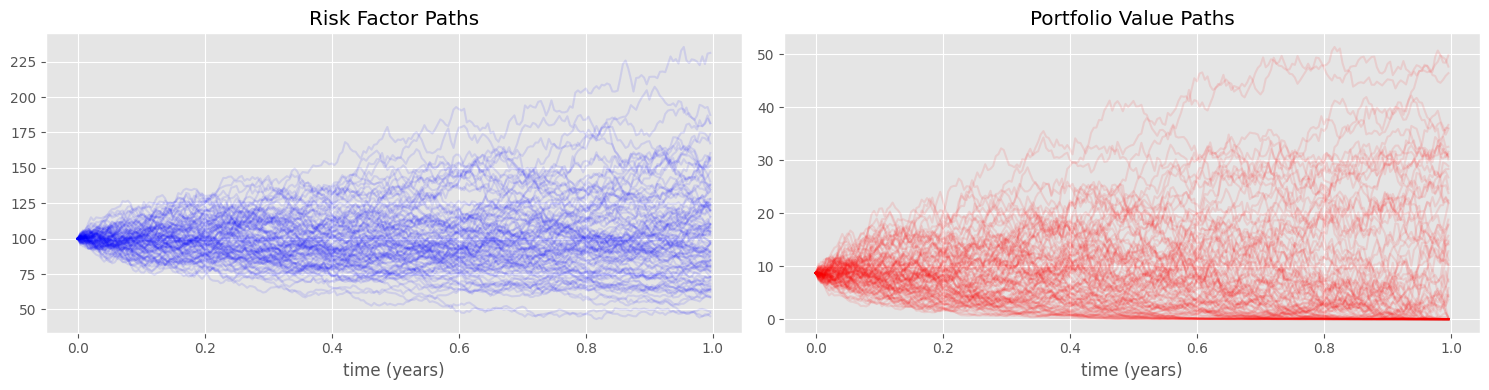

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(time_grid, S_paths[:100, :].T, color='blue', alpha=0.1)
axs[0].set_title('Risk Factor Paths')
axs[0].set_xlabel('time (years)')
axs[1].plot(time_grid, mtm_paths[:100, :].T, color='red', alpha=0.1)
axs[1].set_title('Portfolio Value Paths')
axs[1].set_xlabel('time (years)')
plt.tight_layout()
plt.show()

In [77]:
Nq      = 100
Nq_tail = int(0.1*Nq)//2

q_main              = np.arange(1, N) / N
q_ltail             = np.linspace(0, 0.01, Nq_tail+2)[1:-1]
q_utail             = np.linspace(0.99, 1, Nq_tail+2)[1:-1]
q_all               = np.sort(np.unique(np.concatenate([q_ltail, q_main, q_utail])))
sample_quantiles    = np.quantile(mtm_paths[:, ind_tref], q_all)

In [78]:
S_jlsmc     = 4
S_glsmc     = 2
X_jlsmc     = np.column_stack([eval_genlaguerre(s, 0, mtm_paths[:, ind_tref]) for s in range(S_jlsmc+1)])
X_glsmc     = np.column_stack([mtm_paths[:, ind_tref]**r for r in range(S_glsmc+1)])

mtm_test        = np.linspace(np.min(mtm_paths[:, ind_tref]), np.max(mtm_paths[:, ind_tref]), 1000)
X_test_jlsmc    = np.column_stack([eval_genlaguerre(s, 0, mtm_test) for s in range(S_jlsmc+1)])
X_test_glsmc    = np.column_stack([mtm_test**r for r in range(S_glsmc+1)])

X_quant_jlsmc = np.column_stack([eval_genlaguerre(s, 0, sample_quantiles) for s in range(S_jlsmc+1)])
X_quant_glsmc = np.column_stack([sample_quantiles**r for r in range(S_glsmc+1)])

order_mom = 4
y_hat_jlsmc = np.zeros((X_test_jlsmc.shape[0], order_mom+1))
moms_quant_jlsmc = np.zeros((len(sample_quantiles), order_mom+1))
for j in range(1, order_mom+1):
    y = mtm_diff_paths[:, ind_tref]**j
    if j%2 != 0:
        model                       = LinearRegression(fit_intercept=False)
        model.fit(X_jlsmc, y)
        y_hat_jlsmc[:, j-1]         = model.predict(X_test_jlsmc)
        moms_quant_jlsmc[:, j-1]    = model.predict(X_quant_jlsmc)

    else:
        glm                         = sm.GLM(y, X_jlsmc, family=sm.families.Gaussian(sm.families.links.Log())).fit()
        y_hat_jlsmc[:, j-1]         = glm.predict(X_test_jlsmc)
        moms_quant_jlsmc[:, j-1]    = glm.predict(X_quant_jlsmc)

'''
model       = LinearRegression(fit_intercept=False)
model.fit(X_glsmc, mtm_diff_paths[:, ind_tref]**2)
y_hat_glsmc = model.predict(X_test_glsmc)
'''
glm                 = sm.GLM(y, X_glsmc, family=sm.families.Gaussian(sm.families.links.Log())).fit()
y_hat_glsmc         = glm.predict(X_test_glsmc)
moms_quant_glsmc    = glm.predict(X_quant_glsmc)

In [79]:
mu1_test_jlsmc  = y_hat_jlsmc[:, 0]
mu1_test_glsmc  = np.zeros_like(mtm_test)
mu1_quant_jlsmc = moms_quant_jlsmc[:, 0]
mu1_quant_glsmc = np.zeros_like(sample_quantiles)

mu2_test_jlsmc  = y_hat_jlsmc[:, 1] - y_hat_jlsmc[:, 0]**2
mu2_test_glsmc  = y_hat_glsmc
mu2_quant_jlsmc = moms_quant_jlsmc[:, 1] - moms_quant_jlsmc[:, 0]**2
mu2_quant_glsmc = moms_quant_glsmc

mu3_test_jlsmc  = y_hat_jlsmc[:, 2] - 3*y_hat_jlsmc[:, 0]*y_hat_jlsmc[:, 1] + 2*y_hat_jlsmc[:, 0]**3
mu3_test_glsmc  = np.zeros_like(mtm_test)
mu3_quant_jlsmc = moms_quant_jlsmc[:, 2] - 3*moms_quant_jlsmc[:, 0]*moms_quant_jlsmc[:, 1] + 2*moms_quant_jlsmc[:, 0]**3
mu3_quant_glsmc = np.zeros_like(sample_quantiles)

mu4_test_jlsmc  = y_hat_jlsmc[:, 3] - 4*y_hat_jlsmc[:, 0]*y_hat_jlsmc[:, 2] + 6*y_hat_jlsmc[:, 0]**2*y_hat_jlsmc[:, 1] - 3*y_hat_jlsmc[:, 0]**4
mu4_test_glsmc  = 3*y_hat_glsmc**2
mu4_quant_jlsmc = moms_quant_jlsmc[:, 3] - 4*moms_quant_jlsmc[:, 0]*moms_quant_jlsmc[:, 2] + 6*moms_quant_jlsmc[:, 0]**2*moms_quant_jlsmc[:, 1] - 3*moms_quant_jlsmc[:, 0]**4
mu4_quant_glsmc = 3*moms_quant_glsmc**2

skew_test_jlsmc     = mu3_test_jlsmc / mu2_test_jlsmc**(3/2)
skew_test_glsmc     = mu3_test_glsmc / mu2_test_glsmc**(3/2)
skew_quant_jlsmc    = mu3_quant_jlsmc / mu2_quant_jlsmc**(3/2)
skew_quant_glsmc    = mu3_quant_glsmc / mu2_quant_glsmc**(3/2)

kurt_test_jlsmc     = mu4_test_jlsmc / mu2_test_jlsmc**2
kurt_test_glsmc     = mu4_test_glsmc / mu2_test_glsmc**2
kurt_quant_jlsmc    = mu4_quant_jlsmc / mu2_quant_jlsmc**2
kurt_quant_glsmc    = mu4_quant_glsmc / mu2_quant_glsmc**2

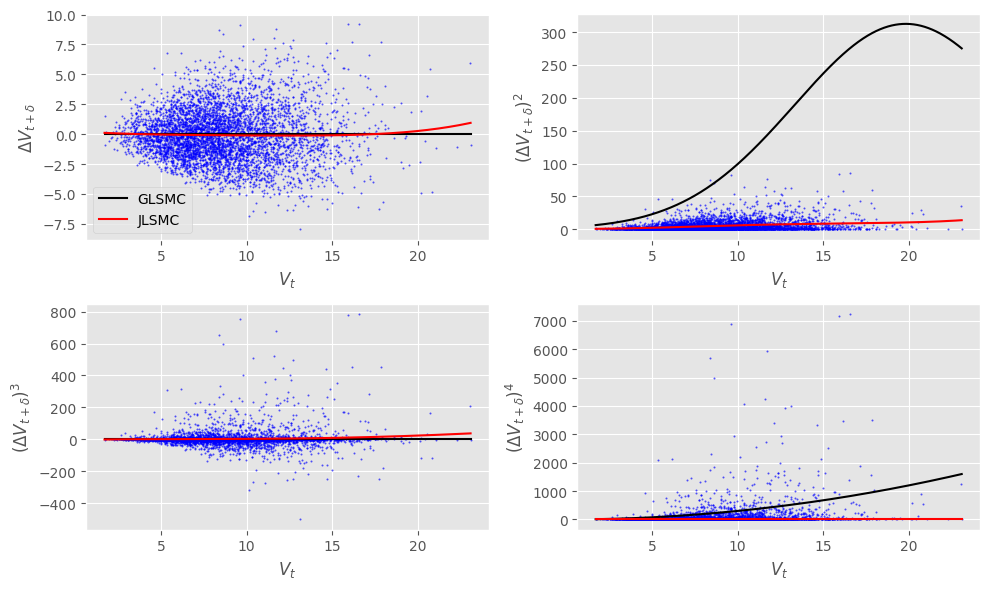

In [80]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].scatter(mtm_paths[:, ind_tref], mtm_diff_paths[:, ind_tref], alpha=0.5, s=1, color='blue')
axs[0, 0].plot(mtm_test, np.zeros_like(mtm_test), color='black', label='GLSMC')
axs[0, 0].plot(mtm_test, y_hat_jlsmc[:, 0], color='red', label='JLSMC')
#axs[0, 0].scatter(sample_quantiles, moms_quant_jlsmc[:, 0], s=10, color='red', label='JLSMC quantiles')
axs[0, 0].set_xlabel('$V_t$')
axs[0, 0].set_ylabel('$\\Delta V_{t+\\delta}$')
axs[0, 0].legend()

axs[0, 1].scatter(mtm_paths[:, ind_tref], mtm_diff_paths[:, ind_tref]**2, alpha=0.5, s=1, color='blue')
axs[0, 1].plot(mtm_test, y_hat_glsmc, color='black', label='GLSMC')
axs[0, 1].plot(mtm_test, y_hat_jlsmc[:, 1], color='red', label='JLSMC')
#axs[0, 1].scatter(sample_quantiles, moms_quant_jlsmc[:, 1], s=10, color='red', label='JLSMC quantiles')
axs[0, 1].set_xlabel('$V_t$')
axs[0, 1].set_ylabel('$\\left(\\Delta V_{t+\\delta}\\right)^2$')

axs[1, 0].scatter(mtm_paths[:, ind_tref], mtm_diff_paths[:, ind_tref]**3, alpha=0.5, s=1, color='blue')
axs[1, 0].plot(mtm_test, np.zeros_like(mtm_test), color='black', label='GLSMC')
axs[1, 0].plot(mtm_test, y_hat_jlsmc[:, 2], color='red', label='JLSMC')
#axs[1, 0].scatter(sample_quantiles, moms_quant_jlsmc[:, 2], s=10, color='red', label='JLSMC quantiles')
axs[1, 0].set_xlabel('$V_t$')
axs[1, 0].set_ylabel('$\\left(\\Delta V_{t+\\delta}\\right)^3$')

axs[1, 1].scatter(mtm_paths[:, ind_tref], mtm_diff_paths[:, ind_tref]**4, alpha=0.5, s=1, color='blue')
axs[1, 1].plot(mtm_test, 3*mtm_test**2, color='black', label='GLSMC')
axs[1, 1].plot(mtm_test, y_hat_jlsmc[:, 4], color='red', label='JLSMC')
# axs[1, 1].scatter(sample_quantiles, moms_quant_jlsmc[:, 4], s=10, color='red', label='JLSMC quantiles')
axs[1, 1].set_xlabel('$V_t$')
axs[1, 1].set_ylabel('$\\left(\\Delta V_{t+\\delta}\\right)^4$')

plt.tight_layout()
plt.show()

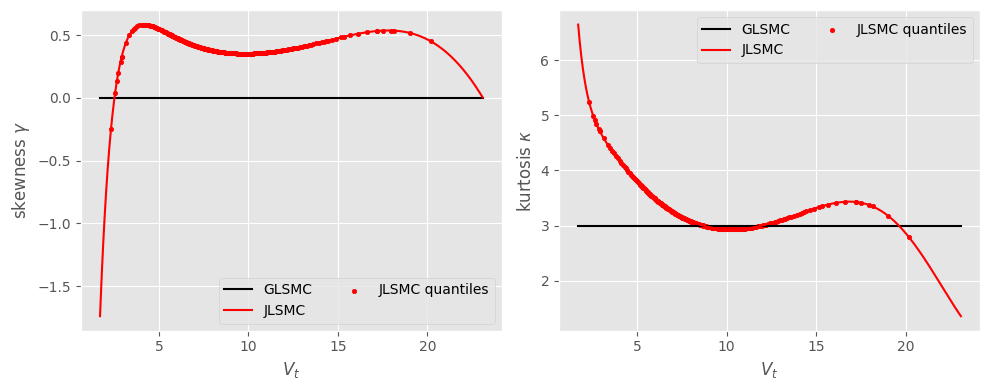

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# skewness plot
axs[0].plot(mtm_test, skew_test_glsmc, color='black', label='GLSMC')
axs[0].plot(mtm_test, skew_test_jlsmc, color='red', label='JLSMC')
axs[0].scatter(sample_quantiles, skew_quant_jlsmc, color='red', s=10, label='JLSMC quantiles')
axs[0].set_xlabel('$V_t$')
axs[0].set_ylabel('skewness $\\gamma$')
axs[0].legend(ncols=2)

# kurtosis plot
axs[1].plot(mtm_test, kurt_test_glsmc, color='black', label='GLSMC')
axs[1].plot(mtm_test, kurt_test_jlsmc, color='red', label='JLSMC')
axs[1].scatter(sample_quantiles, kurt_quant_jlsmc, color='red', s=10, label='JLSMC quantiles')
axs[1].set_xlabel('$V_t$')
axs[1].set_ylabel('kurtosis $\\kappa$')
axs[1].legend(ncols=2)

plt.tight_layout()
plt.show()

In [82]:
from j_johnson_M import f_johnson_M

johnson_params_quant    = np.zeros((len(sample_quantiles), 4))
johnson_jtypes_quant    = np.zeros(len(sample_quantiles), dtype=int)
jtypes_map              = {'SL': 1, 'SU': 2, 'SB': 3, 'SN': 4, 'ST': 5}

for i in range(len(sample_quantiles)):
    coeffs, jtype, _ = f_johnson_M(mu1_quant_jlsmc[i], sqrt(mu2_quant_jlsmc[i]), skew_quant_jlsmc[i], kurt_quant_jlsmc[i])
    johnson_params_quant[i, :] = coeffs
    johnson_jtypes_quant[i] = jtypes_map[jtype]

c:\Users\CF518AW\OneDrive - EY\Documents\STAGE\EY-Initial-Margin\j_johnson_M.py:311: RuntimeWarning: invalid value encountered in sqrt
  y = np.log(np.sqrt(y)+np.sqrt(y+one))


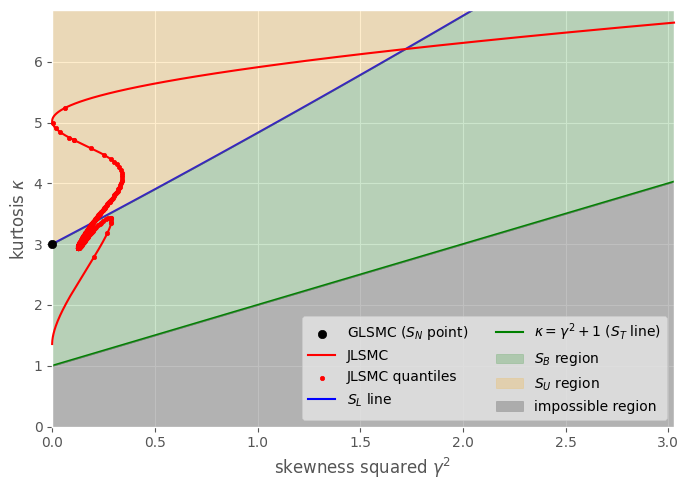

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter([skew_test_glsmc[0]**2], [kurt_test_glsmc[0]], color='black', label='GLSMC ($S_N$ point)', zorder=3, clip_on=False)
ax.plot(skew_test_jlsmc**2, kurt_test_jlsmc, color='red', label='JLSMC', zorder=3, clip_on=False)
ax.scatter(skew_quant_jlsmc**2, kurt_quant_jlsmc, color='red', s=10, label='JLSMC quantiles', zorder=3, clip_on=False)

omega       = np.linspace(1, 1.2, 100)
beta1_sl    = (omega-1) * (omega+2)**2
kurt_sl     = omega**4 + 2*omega**3 + 3*omega**2 - 3
ax.plot(beta1_sl, kurt_sl, color='blue', label='$S_L$ line', zorder=1)

beta1_lim   = np.linspace(np.min(skew_test_jlsmc**2), np.max(skew_test_jlsmc**2), 100)
kurt_lim    = 1 + beta1_lim
ax.plot(beta1_lim, kurt_lim, color='green', label='$\\kappa = \\gamma^2 + 1$ ($S_T$ line)', zorder=1)
interp_sl       = interp1d(beta1_sl, kurt_sl, bounds_error=False, fill_value="extrapolate")
kurt_sl_interp  = interp_sl(beta1_lim)
ax.fill_between(beta1_lim, kurt_lim, kurt_sl_interp, color='green', alpha=0.2, label='$S_B$ region', zorder=1)

max_kurt = max(np.max(kurt_test_jlsmc), np.max(kurt_test_glsmc), np.max(kurt_sl), np.max(kurt_lim))
ax.fill_between(beta1_sl, kurt_sl, max_kurt*np.ones_like(kurt_sl), color='orange', alpha=0.2, label='$S_U$ region', zorder=1)
ax.fill_between(beta1_lim, kurt_lim, np.zeros_like(kurt_lim), color='grey', alpha=0.5, label='impossible region', zorder=1)

ax.set_xlabel('skewness squared $\\gamma^2$')
ax.set_ylabel('kurtosis $\\kappa$')
ax.set_xlim(0, np.max(skew_test_jlsmc**2))
ax.set_ylim(0, max_kurt)
ax.legend(ncol=2)
plt.tight_layout()
plt.show()

In [ ]:
johnson_var_quant = np.zeros_like(sample_quantiles)

for i in range(len(sample_quantiles)):
    if johnson_jtypes_quant[i] == 1:
        johnson_var_quant[i] = lognorm.ppf(alpha, s=1/johnson_params_quant[i, 1], loc=johnson_params_quant[i, 2]*exp(-johnson_params_quant[i, 0]/johnson_params_quant[i, 1]), scale=johnson_params_quant[i, 3])
    elif johnson_jtypes_quant[i] == 2:
        johnson_var_quant[i] = johnsonsu.ppf(alpha, a=johnson_params_quant[i, 0], b=johnson_params_quant[i, 1], loc=johnson_params_quant[i, 2], scale=johnson_params_quant[i, 3])
    elif (johnson_jtypes_quant[i] == 3) or (johnson_jtypes_quant[i] == 5):
        johnson_var_quant[i] = johnsonsb.ppf(alpha, a=johnson_params_quant[i, 0], b=johnson_params_quant[i, 1], loc=johnson_params_quant[i, 2], scale=johnson_params_quant[i, 3])
    elif johnson_jtypes_quant[i] == 4:
        johnson_var_quant[i] = norm.ppf(alpha, loc=johnson_params_quant[i, 2], scale=johnson_params_quant[i, 3])